In [29]:
from __future__ import division
import os
import sys
import pandas as pd
import numpy as np


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('xtick', labelsize=20) 

### Define helper functions
Just some basic tools that'll be helpful throughout the analysis

In [57]:
# tools for translating between 2D and 1D position indices for the calibration grid
calibGridDims = [5,5]
def getPtIdx(x,y):
    ptIdx = ((y-1)*calibGridDims[0]) + x
    return ptIdx

def getRowIdx(ptIdx):
    print ptIdx
    row,col = np.unravel_index(ptIdx-1, (calibGridDims[0],calibGridDims[1]))
    row = row+1
    col = col+1
    return row, col


In [178]:
# convert between cartesian and polar coordinates
def polar2cart(dist, angle):
    x = dist * np.cos(np.deg2rad(angle))
    y = dist * np.sin(np.deg2rad(angle))
    return x,y

In [185]:
# base plot for accuracy plotting
def plotCalibration(calibPts, figTitle):
    """
    calibPts is a nx3 array, where each row represents one pt to be plotted. 
    Each row should contain, in order: distance, angle, and RMS for that point
    """
    
    # start figure
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(figTitle, fontsize=20, fontweight='bold')
    ax = fig.add_subplot(111)
    xRange = yRange = [-3.5, 3.5]
    ax.set_ylim(yRange[0], yRange[1])
    ax.set_xlim(xRange[0], xRange[1])

    # add circle at center for reference
    ax.scatter(0,0, s=1000, facecolor='black', alpha=.4)  # put circle at center for reference
    
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks([])

    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks([])

    # Add circles as tickmarks
    for r in range(1,4):
        circle1 = plt.Circle((0,0), r, color='k', fill=False, ls=':', alpha=.6)
        ax.add_artist(circle1)

    # add cross lines
    lineExtent = 2.75
    ax.plot([-lineExtent, lineExtent], [-lineExtent, lineExtent], ls=':', color='k')
    ax.plot([-lineExtent, lineExtent], [lineExtent, -lineExtent], ls=':', color='k')

    # add labels
    ax.text(xRange[1]+.1, 0, '0$^\circ$ ', fontsize=15, verticalalignment='center', horizontalalignment='left')
    ax.text(lineExtent+.1, lineExtent+.1, '45$^\circ$ ', fontsize=15, horizontalalignment='left')
    ax.text(0, yRange[1]+.1, '90$^\circ$ ', fontsize=15, horizontalalignment='center')
    ax.text(-lineExtent-.1, lineExtent+.1, '135$^\circ$ ', fontsize=15, horizontalalignment='right')
    ax.text(xRange[0]-.1, 0, '180$^\circ$ ', fontsize=15, verticalalignment='center', horizontalalignment='right')
    ax.text(-lineExtent, -lineExtent-.1, '225$^\circ$ ', fontsize=15, horizontalalignment='right')
    ax.text(0, yRange[0]-.1, '270$^\circ$ ', fontsize=15, verticalalignment='top', horizontalalignment='center')
    ax.text(lineExtent+.1, -lineExtent-.1, '315$^\circ$ ', fontsize=15, horizontalalignment='left')

    for i in range(1,4):
        ax.text(np.cos(np.deg2rad(45))*i + .15, 
                np.sin(np.deg2rad(45))*i - .1, 
                str(i) + '$^\circ$ ', 
                fontsize=15,
                weight='bold',
                horizontalalignment='left')
        
    ####################### Plot the datapoints
    for pt in calibPts:
        dist = pt[0]
        angle = pt[1]
        rms = pt[2]
        
        x,y = polar2cart(dist, angle)
        
        # plot the location
        loc = plt.Circle((x,y), .1, color='firebrick')
        
        # plot the rms
        spread = plt.Circle((x,y), rms/2, color='firebrick', alpha=.4)
        
        ax.add_artist(loc)
        ax.add_artist(spread)
        

## Load/Prep Data

In [4]:
# read in combined subjects dataframe
df = pd.read_csv('allConds_uniqueSubjs.csv', sep='\t')

In [5]:
df.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg


### convert condition labels cols to categorical dtype
This will create columns with unique codes for each subject, and unique codes for each condition

In [10]:
# convert to categorical dtype
df['subjCode'] = df.loc[:,'subj'].astype('category')
df['offsetCode'] = df.loc[:,'offset'].astype('category')

# show the numbers instead of labels
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
df.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset,subjCode,offsetCode
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg,0,0
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg,0,0
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg,0,0
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg,0,0
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg,0,0


### remove invalid trials from the dataset

In [13]:
print df.shape
dfClean = df[df.percentValid >= .8]
print dfClean.shape

(525, 12)
(508, 12)


# Analyze Calibration Accuracy at 0deg offset
How accurately do the gaze points map on to the calibration grid locations when the grid is positioned directly in front of the participant

In [15]:
# grab the 0-deg offset trials
df_0deg = dfClean.loc[dfClean.offsetCode==0, :]

In [58]:
df_0deg.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset,subjCode,offsetCode
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg,0,0
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg,0,0
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg,0,0
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg,0,0
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg,0,0


Calculate an overall mean across all calibration points for each subject

In [60]:
subj_mean = df_0deg.groupby('subjCode').mean()

In [61]:
subj_mean

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,offsetCode
subjCode,,,,,,,,
0,0.5876,287.9324,2.5988,629.9164,899.7284,0.9672,13,0
1,0.3400,265.9180,1.4120,484.2228,732.5024,0.9632,13,0
2,0.6020,265.9444,1.1564,459.6152,681.3160,0.9376,13,0


Calculate the group mean and standard error

In [68]:
group_mean = subj_mean.mean()
group_sem = subj_mean.sem()
print group_mean

RMS               0.509867
centAngle       273.264933
centDist          1.722400
centX           524.584800
centY           771.182267
percentValid      0.956000
ptIdx            13.000000
offsetCode        0.000000
dtype: float64


### Plot the group mean at 0-deg offset

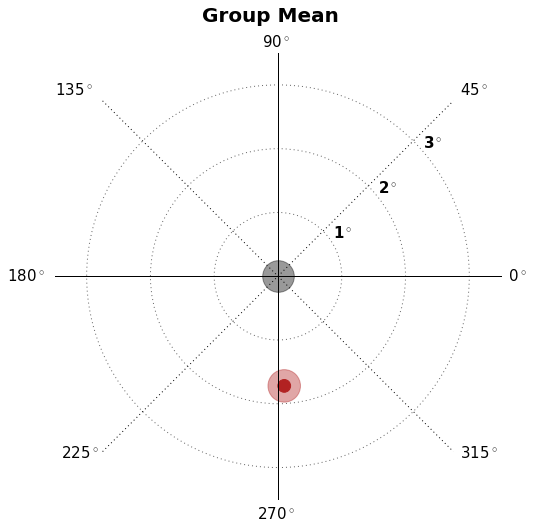

In [188]:
groupMeanPt = [group_mean.centDist, group_mean.centAngle, group_mean.RMS]
pts = [groupMeanPt]
plotCalibration(pts, 'Group Mean')